# Capstone Two - 5 Extended Modeling: AutoML mljar-supervised<a id='5'></a>

## 5.1 Contents<a id='5.1'></a>
* [5 Extended Modeling](#5)
  * [5.1 Contents](#5.1)
  * [5.2 Imports](#5.2)
  * [5.3 Load The Data](#5.3)
  * [5.4 Data Processing and Modeling](#5.4)
  * [5.5 Evaluation](#5.5)
    * [5.5.1 MAPE](#5.5.1)
    * [5.5.2 Scatter plots](#5.5.2)
    * [5.5.3 Distribution of residuals](#5.5.3)
  * [5.6 Save Data](#5.6) 

## 5.2 Imports<a id='5.2'></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from library.sb_utils import save_file

In [3]:
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML

## 5.3 Load The Data<a id='5.3'></a>

In [4]:
data_dir = '../data/'

data_ori = pd.read_csv(data_dir+'train_all_groups.csv')
data_ori.head(3)

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,transferred,year,month
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1


From the pre-processing part, we know that the daily oil price and holiday/non_holiday have little importance in the prediction, so we drop these columns.

In [5]:
data = data_ori[['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'transactions']]
data.set_index('date', inplace = True)
data.head(3)

,store_nbr,family,sales,onpromotion,transactions
date,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,0.0
2013-01-01,1,BABY CARE,0.0,0,0.0
2013-01-01,1,BEAUTY,0.0,0,0.0


## 5.4 Data Processing and Modeling<a id='5.4'></a>

In [6]:
stores = data['store_nbr'].unique()
families = data['family'].unique()

In [7]:
grp = data.groupby(['store_nbr', 'family'])

In [8]:
stores1 = [*range(1, 7, 1)] # No.1-6 stores
families1 = ['BREAD/BAKERY', 'DAIRY', 'GROCERY I']

In [9]:
# df = pd.DataFrame()
mAPE = []
groups = []
df_pred = pd.DataFrame()
df_actual = pd.DataFrame()

for s in stores1:
    for f in families1:

    ### Data Processing ###
        df =  grp.get_group((s, f))
        group = str(s)+","+f
        df = df.drop(columns=['store_nbr', 'family'])

        df.index = pd.DatetimeIndex(df.index).to_period('D')
        df = df.resample('1D').mean().ffill() # fill time gaps
        
        # Sales are zeros on New Year's Day (Store Closed)
        df.loc[['2014-01-01']] = df.loc[['2013-12-31']].values
        df.loc[['2015-01-01']] = df.loc[['2014-12-31']].values
        df.loc[['2016-01-01']] = df.loc[['2015-12-31']].values
        df.loc[['2017-01-01']] = df.loc[['2016-12-31']].values

        df = df.to_timestamp(freq='D') # from period to datetime

        # Weekday or Weekend - impartant feature     
        df = df.reset_index()
        df['day_of_week'] = df['date'].dt.day_name()
        df.loc[df['day_of_week'].isin(['Monday','Tuesday','Wednesday','Thursday','Friday']), 'day_of_week'] = 'weekday'
        df.loc[df['day_of_week'].isin(['Saturday','Sunday']), 'day_of_week'] = 'weekend'
        dummy_dow = pd.get_dummies(df['day_of_week'], dtype=float)
        df = pd.concat([df, dummy_dow], axis=1)
        
        # lags
        # For sales
        df['sales_lag1'] = df['sales'].shift(1)
        df['sales_lag7'] = df['sales'].shift(7)
        df['sales_lag14'] = df['sales'].shift(14)
        df['sales_7days_avg'] = df['sales_lag1'].rolling(7).mean().round(1)
        df['sales_14days_avg'] = df['sales_lag1'].rolling(14).mean().round(1)
        # For transactions
        df['trans_lag1'] = df['transactions'].shift(1)
        df['trans_lag7'] = df['transactions'].shift(7)
        df['trans_lag14'] = df['transactions'].shift(14)
        df['trans_7days_avg'] = df['trans_lag1'].rolling(7).mean().round(1)
        df['trans_14days_avg'] = df['trans_lag1'].rolling(14).mean().round(1)

        df = df.drop(['day_of_week', 'transactions'], axis=1)
        df = df.set_index('date')
        
        df = df[15:] #start from day 16
        X_train, X_test, y_train, y_test = train_test_split(df[df.columns[1:]], df['sales'], test_size=16, shuffle=False)
        
    ### Modeling ### 
        automl = AutoML()
        automl.fit(X_train, y_train)

        y_pred = automl.predict(X_test)
        
        APE_y = abs( (y_test - y_pred) / y_test)
        mAPE_y = np.mean(APE_y)
        print(group+' MAPE: '+str(mAPE_y))
    
        mAPE.append(mAPE_y)        
        groups.append(group)
        df_pred[group] = y_pred
        df_actual[group] = y_test       

AutoML directory: AutoML_22
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 111.343365 trained in 0.18 seconds
2_DecisionTree rmse 62.406839 trained in 4.7 seconds
3_Linear rmse 66.68955 trained in 1.4 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 60.892054 trained in 1.89 seconds
5_Default_NeuralNetwork rmse 62.861333 trained in 0.3 seconds
6_Default_RandomForest rmse 58.859413 trained in 1.87 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 58.136848 trained in 0.12 seconds
AutoML fit time: 14.41 seconds
AutoML best model: Ensemble
1,BREAD/BAKERY MAPE: 0.20554752506634788
AutoML directory: AutoML_23
The task is regression with

In [10]:
df_pred.index = df_actual.index

## 5.5 Evaluation<a id='5.5'></a>

### 5.5.1 MAPE<a id='5.5.1'></a>

In [11]:
df_mape = pd.DataFrame()
df_mape['Group'] = groups
df_mape['MAPE'] = mAPE

print("\033[1m"+"Sorted MAPE values:")
df_mape.sort_values(by=['MAPE'])

Sorted MAPE values:


,Group,MAPE
13,"5,DAIRY",0.059276
3,"2,BREAD/BAKERY",0.089013
14,"5,GROCERY I",0.089427
7,"3,DAIRY",0.092602
8,"3,GROCERY I",0.096102
6,"3,BREAD/BAKERY",0.103204
12,"5,BREAD/BAKERY",0.103226
17,"6,GROCERY I",0.108808
16,"6,DAIRY",0.115788
10,"4,DAIRY",0.137061


In [12]:
print("\033[1m"+"Best 3 MAPE:")
df_best = df_mape.nsmallest(3, 'MAPE')
df_best

Best 3 MAPE:


,Group,MAPE
13,"5,DAIRY",0.059276
3,"2,BREAD/BAKERY",0.089013
14,"5,GROCERY I",0.089427


In [13]:
print("\033[1m"+"Worst 3 MAPE:")
df_worst = df_mape.nlargest(3, 'MAPE')
df_worst

Worst 3 MAPE:


,Group,MAPE
0,"1,BREAD/BAKERY",0.205548
11,"4,GROCERY I",0.195605
9,"4,BREAD/BAKERY",0.189619


**The Best MAPE is about 6%, and the Worst MAPE is about 21%.**

### 5.5.2 Scatter plots<a id='5.5.2'></a>

In [14]:
def scatterplots(columns, ncol=None, figsize=(8, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.25, hspace=0.4)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = df_actual[col], y = df_pred[col], alpha=0.8)
        ax.set(xlabel="Aactual values", ylabel="Predicted values", title=col)
        min_val = min(df_actual[col])
        ax.axline((min_val, min_val), slope=1, color = 'red')    
    nsubplots = nrow * ncol    
    # for empty in range(i+1, nsubplots):
    #     axes.flatten()[empty].set_visible(False)

Upper: Best 3, Lower: Worst 3


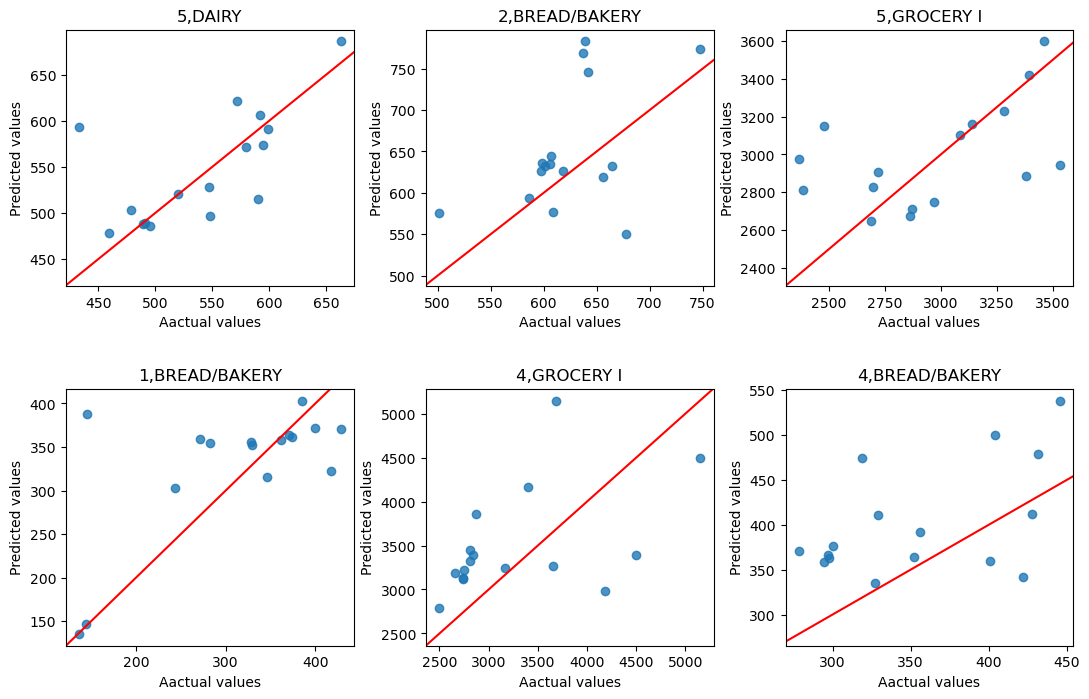

In [15]:
%matplotlib inline

df_comb = pd.concat([df_best, df_worst])
features = df_comb.Group
print("\033[1m"+"Upper: Best 3, Lower: Worst 3")
scatterplots(features, ncol=3, figsize=(13, 8))

**The scatter points in the upper Best 3 plots are closer to the y=x line than those in the lower 3 plots.**

### 5.5.3 Distribution of residuals<a id='5.5.3'></a>

In [16]:
# Residuals
df_resid = df_actual - df_pred
# PEs
df_pe = (df_actual - df_pred) / df_actual

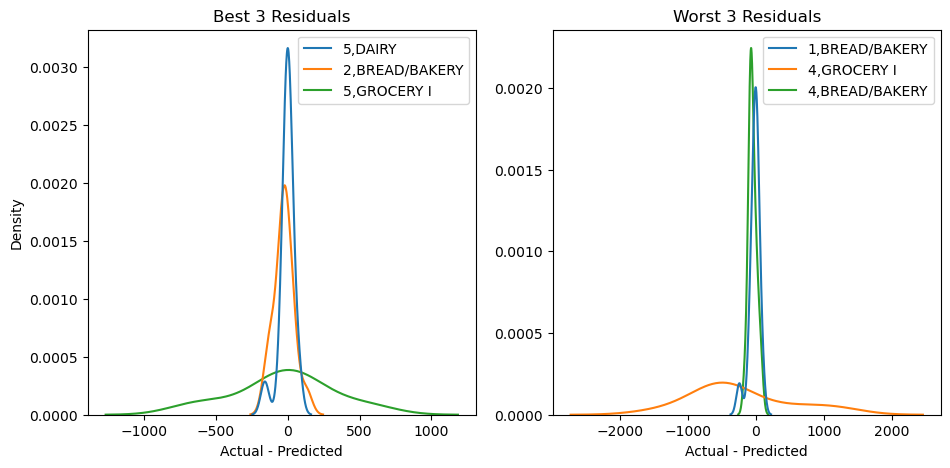

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
sns.kdeplot(ax=axes[0], data=df_resid[df_best.Group])
axes[0].set_title("Best 3 Residuals")
axes[0].set_xlabel("Actual - Predicted")
sns.kdeplot(ax=axes[1], data=df_resid[df_worst.Group])
axes[1].set_title("Worst 3 Residuals")
axes[1].set_xlabel("Actual - Predicted")
axes[1].set_ylabel("")
plt.show()

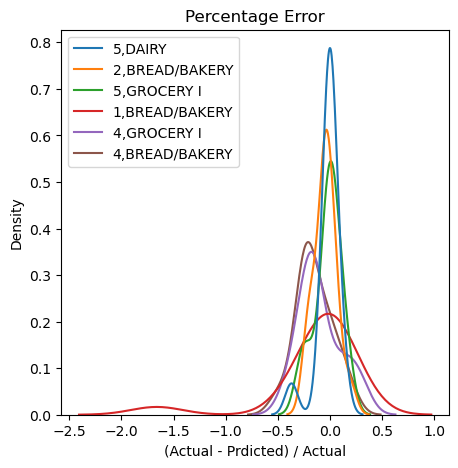

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(data=df_pe[df_comb.Group])
plt.title("Percentage Error")
plt.xlabel("(Actual - Prdicted) / Actual")
plt.show()

**From the Distribution of Residuals plots, we cannot figure out how the "Best 3" is better than the "Worst 3".\
From the Percentage Error plot, we can clear see that the center lines of the "Best 3" are closer to zero and their distributions are also more concentrated.**

## 5.6 Save Data<a id='5.6'></a>

In [19]:
datapath = '../data'
save_file(df_pred, 'df_pred_3.csv', datapath)
save_file(df_mape, 'df_mape_3.csv', datapath)

Writing file.  "../data/df_pred_3.csv"
Writing file.  "../data/df_mape_3.csv"
